(ref : https://nlp.seas.harvard.edu/2018/04/03/attention.html)
<br><br>
## Table of Contents
- [Model Architecture](#scrollTo=7THo9Qx9nVPw)
  - Encoder and Decoder Stacks
    - Encoder
    - Decoder
    - Attention
    - Applications of Attention in our Model
  - Position-wise Feed-Forward Networks
  - Embeddings and Softmax
  - Positional Encoding
  - Full Model

- [Training](#scrollTo=99wO8gdYnX1G)
  - Batches and Masking
  - Training Loop
  - Training Data and Batching
  - Hardware and Schedule
  - Optimizer
  - Regularization
    - Label Smoothing


In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import math, copy, time
from torch.autograd import Variable
import matplotlib.pyplot as plt
import seaborn
seaborn.set_context(context='talk')

( [Table of Contents](#scrollTo=OCXuQtk-lXC0)\ )
## Model Architecture

<img src="https://nlp.seas.harvard.edu/images/the-annotated-transformer_14_0.png" height=500px>

In [2]:
class EncoderDecoder(nn.Module):
    """
    A standard Encoder-Decoder architecture. Base for this and many other models.
    """
    def __init__(self, encoder, decoder, src_embed, tgt_embed, generator) -> None:
        super(EncoderDecoder, self).__init__()
        self.encoder = encoder
        self.decoder = decoder
        self.src_embed = src_embed
        self.tgt_embed = tgt_embed
        self.generator = generator
    
    def forward(self, src, tgt, src_mask, tgt_mask):
        "Take in and process masked src and target sequences."
        memory = self.encode(src, src_mask)
        out = self.decode(memory, tgt, src_mask, tgt_mask)
        return out
    
    def encode(self, src, src_mask):
        src_embeded = self.src_embed(src)
        memory = self.encoder(src_embeded, src_mask)
        return memory
    
    def decode(self, memory, tgt, src_mask, tgt_mask):
        tgt_embeded = self.tgt_embed(tgt)
        out = self.decoder(tgt_embeded, memory, src_mask, tgt_mask)
        return out


class Generator(nn.Module):
    "Define standard linear + softmax generation step."
    def __init__(self, d_model, vocab) -> None:
        super(Generator, self).__init__()
        self.proj = nn.Linear(d_model, vocab)
    
    def forward(self, x):
        return F.log_softmax(self.proj(x), dim=-1)

### Encoder and Decoder Stacks

In [3]:
# utils for layers
def clones(module, N):
    "Produce N identical layers"
    return nn.ModuleList([copy.deepcopy(module) for _ in range(N)])


class LayerNorm(nn.Module):
    "Construct a layernorm module."
    def __init__(self, features, eps=1e-6) -> None:
        super(LayerNorm, self).__init__()
        self.a_2 = nn.Parameter(torch.ones(features))
        self.b_2 = nn.Parameter(torch.zeros(features))
        self.eps = eps
    
    def forward(self, x):
        mean = x.mean(-1, keepdim=True)
        std = x.std(-1, keepdim=True)
        return self.a_2 * (x-mean) / (std+self.eps) + self.b_2


class SublayerConnection(nn.Module):
    """
    A residual connection followed by a layer norm.
    Note for code simplicity the norm is first as opposed to last.
    """
    def __init__(self, size, dropout) -> None:
        super(SublayerConnection, self).__init__()
        self.norm = LayerNorm(size)
        self.dropout = nn.Dropout(dropout)
    
    def forward(self, x, sublayer):
        "Apply residual connection to any sublayer with the same size."
        return x + self.dropout(sublayer(self.norm(x)))

In [4]:
# Encoder
class Encoder(nn.Module):
    "Core encoder is a stack of N layers."
    def __init__(self, layer, N) -> None:
        super(Encoder, self).__init__()
        self.layers = clones(layer, N)
        self.norm = LayerNorm(layer.size)
    
    def forward(self, x, mask):
        "Pass the input (and mask) through each layer in turn."
        for layer in self.layers:
            x = layer(x, mask)
        return self.norm(x)


class EncoderLayer(nn.Module):
    "Encoder is made up of self-attn and feed forward"
    def __init__(self, size, self_attn, feed_forward, dropout) -> None:
        super(EncoderLayer, self).__init__()
        self.self_attn = self_attn
        self.feed_forward = feed_forward
        self.sublayer = clones(SublayerConnection(size, dropout), 2)
        self.size = size
    
    def forward(self, x, mask):
        x = self.sublayer[0](x, lambda x : self.self_attn(x, x, x, mask))
        return self.sublayer[1](x, self.feed_forward)

In [5]:
# Decoder
class Decoder(nn.Module):
    "Generic N layer decoder with masking."
    def __init__(self, layer, N) -> None:
        super(Decoder, self).__init__()
        self.layers = clones(layer, N)
        self.norm = LayerNorm(layer.size)
    
    def forward(self, memory, x, src_mask, tgt_mask):
        for layer in self.layers:
            x = layer(memory, x, src_mask, tgt_mask)
        return self.norm(x)


class DecoderLayer(nn.Module):
    "Decoder is made of self-attn, src-attn, and feed forward."
    def __init__(self, size, self_attn, src_attn, feed_forward, dropout) -> None:
        super(DecoderLayer, self).__init__()
        self.self_attn = self_attn
        self.src_attn = src_attn
        self.feed_forward = feed_forward
        self.sublayer = clones(SublayerConnection(size, dropout), 3)
        self.size = size
    
    def forward(self, memory, x, src_mask, tgt_mask):
        x = self.sublayer[0](x, lambda x : self.self_attn(x, x, x, tgt_mask))
        x = self.sublayer[1](x, lambda x : self.src_attn(x, memory, memory, tgt_mask))
        return self.sublayer[2](x, self.feed_forward)


- Figures for Attention
<br><br>
<img src="https://nlp.seas.harvard.edu/images/the-annotated-transformer_33_0.png" height=300px> &emsp;&emsp;&emsp;
<img src="https://nlp.seas.harvard.edu/images/the-annotated-transformer_38_0.png" height=300px>

>>> subsequent_mask (sample)
tensor([[ True, False, False, False, False],
        [ True,  True, False, False, False],
        [ True,  True,  True, False, False],
        [ True,  True,  True,  True, False],
        [ True,  True,  True,  True,  True]])


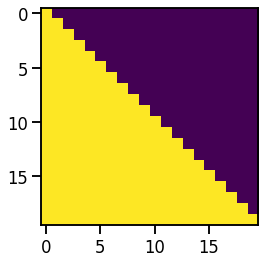

In [6]:
# Attention

## subsequent mask for self-attention in decoder
def subsequent_mask(size):
    "Mask out subsequent positions."
    attn_shape = (1, size, size)
    mask = np.triu(np.ones(attn_shape), k=1).astype('uint8')
    return torch.from_numpy(mask) == 0


print('>>> subsequent_mask (sample)')
print(subsequent_mask(5)[0])
plt.imshow(subsequent_mask(20)[0])
plt.show()


def attention(query, key, value, mask=None, dropout=None):
    "Compute Scaled Dot Product Attention"
    d_k = query.size(-1)
    scores = torch.matmul(query, key.transpose(-2, -1)) / math.sqrt(d_k)
    if mask is not None:
        scores = scores.masked_fill(mask == 0, -1e9)
    p_attn = F.softmax(scores, dim=-1)
    if dropout is not None:
        scores = dropout(p_attn)
    return torch.matmul(p_attn, value), p_attn


class MultiHeadAttention(nn.Module):
    def __init__(self, n_head, d_model, dropout=0.1) -> None:
        "Take in model size and number of heads"
        super(MultiHeadAttention, self).__init__()
        assert d_model % n_head == 0
        # We assume d_v always equals d_k
        self.d_k = d_model // n_head
        self.n_head = n_head
        self.linears = clones(nn.Linear(d_model, d_model), 4)
        self.attn = None
        self.dropout = nn.Dropout(p=dropout)
    
    def forward(self, query, key, value, mask=None):
        if mask is not None:
            # Same task applied to all N heads
            mask = mask.unsqueeze(1)
        n_batches = query.size(0)
        # 1) Do all the linear projections in batch from d_model => n_head * d_k
        query, key, value = [
            ln(x).view(n_batches, -1, self.n_head, self.d_k).transpose(1, 2)
            for ln, x in zip(self.linears, (query, key, value))
        ]
        # 2) Apply attention on all the projected vectors in batch
        x, self.attn = attention(query, key, value, mask=mask, dropout=self.dropout)
        # 3) "Concat" using a view and apply a final linear
        x = x.transpose(1, 2).contiguous().view(n_batches, -1, self.n_head*self.d_k)
        return self.linears[-1](x)

### Full model

In [7]:
def make_model(src_vocab, tgt_vocab, N=6, d_model=512, d_ff=2048, h=8, dropout=0.1):
    "Helper: Construct a model from hyperparameters."
    dpcp = copy.deepcopy
    attn = MultiHeadAttention(h, d_model)
    ff = PositionwiseFeedForward(d_model, d_ff, dropout)
    position = PositionalEncoding(d_model, dropout)
    
    enc_l = EncoderLayer(d_model, dpcp(attn), dpcp(ff), dropout)
    encoder = Encoder(enc_l, N)
    dec_l = DecoderLayer(d_model, dpcp(attn), dpcp(attn), dpcp(ff), dropout)
    decoder = Decoder(dec_l, N)
    src_embed = nn.Sequential(Embeddings(d_model, src_vocab), dpcp(position))
    tgt_embed = nn.Sequential(Embeddings(d_model, tgt_vocab), dpcp(position))
    generator = Generator(d_model, tgt_vocab)
    
    # generate model instance
    model = EncoderDecoder(encoder, decoder, src_embed, tgt_embed, generator)
    
    # Initialize parameters with Glorot / fan_avg.
    for params in model.parameters():
        if params.dim() > 1:
            nn.init.xavier_uniform(params)
    return model

( [Table of Contents](#scrollTo=OCXuQtk-lXC0)\ )
## Training